In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import copy

In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_default_dtype(torch.float)
device = torch.device('mps' if torch.backends.mps.is_available() else 'mps')

In [3]:
data       = np.load("./data/ecg_data.npz")
Xtr        = torch.tensor(data["Xtr"]).type(torch.float).to(device)    #Clean train
Xtr_noise  = torch.tensor(data["Xtr_noise"]).type(torch.float).to(device)  #Noisy train
Xte_noise  = torch.tensor(data["Xte_noise"]).type(torch.float).to(device)  #Noisy test

params = np.load("./data/ecg_params.npz")
W = torch.FloatTensor(params["W"]).type(torch.float).to(device)  #Decoder parameters
V = torch.FloatTensor(params["V"]).type(torch.float).to(device)  #Encoder parameters

In [4]:
class leakyRelu_AE(nn.Module):
    def __repr__(self):
        return {"model":"Leakyrelu","K":self.K,"lr":self.lr,"epoch":self.epochs}
    
    def __init__(self, dim,K,epoch=1000,lr=0.001):
        super(leakyRelu_AE, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(dim, K),
            nn.LeakyReLU(),
            nn.Linear(K,dim)
            )
        self.lr=lr
        self.epochs=epoch
        self.criterion=nn.MSELoss(reduction="mean")
        self.K=K

    def forward(self, x):
        x = self.model(x)
        return x
    
    def reconstruct(self,x,W,V):
        self.model[0].weight.data=W
        self.model[1].weight.data=V
        x=self.model(x)
        return x
    
    def loss(self,X,X_hat):
        return self.criterion(X,X_hat).item()
    
    
    def fit(self,X,R):
        train_loss_list=[]
        optimizer=optim.Adam(self.parameters(),lr=self.lr)
        for epoch in range(self.epochs+1):
            train_loss = 0.0
            self.model.train()
            optimizer.zero_grad()
            output = self.model(X)
            loss = self.criterion(output, R)

            loss.backward()
            optimizer.step()
            train_loss_list.append(loss)
            #if(epoch%100==0):print('Epoch [{}/{}], Train Loss: {:.9f}'.format(epoch, self.epochs, loss))
        #self.saver(self.model.state_dict())
        return loss.item()

    def test(self,X,R):
        self.model.eval()
        with torch.no_grad():
            output=self.model(X)
            loss=self.criterion(output,R)
            return loss

    def print_param(self):
        for param in self.parameters():
            print(f'parameter shape:{param.shape}')
            #print(f'parameter value:{param.data}')
    
    @staticmethod
    def plot_loss(X,X_hat):
        time=len(X)
        plt.plot(range(1, time+1), X.cpu().detach().numpy(), label='Noisy Data')
        plt.plot(range(1, time+1), X_hat.cpu().detach().numpy(), label='Reconstructed Data')
        plt.xlabel('Time')
        plt.ylabel('ECG')
        plt.title('Noisy Data vs. Reconstructed Data')
        plt.legend()
        plt.show()

    def saver(self,best_weights,PATH="./models"):
        name=''.join(f"{key}{val}" for key, val in self.__repr__().items())
        path=PATH+"/"+name
        torch.save(best_weights,path)
    
    # def dataloader(self,X,R,batch_size=128):
    #     dataset = ECGDataset(X,R)
    #     dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True)
    #     return dataloader

In [5]:
model=leakyRelu_AE(100,10,lr=0.01,epoch=1500).to(device)
loss=model.fit(Xtr,Xtr)

In [6]:
K=[k for k in range(10,150,5)]
train_loss_list=[]
test_loss_list=[]
best_k=0
best_loss=np.inf
best_model=None
X_train, X_val, R_train, R_val = train_test_split(Xtr_noise, Xtr, test_size=0.2)
for k in K:
    model=leakyRelu_AE(100,k,lr=0.001,epoch=1500).to(device)
    train_loss=model.fit(X_train,R_train)
    train_loss_list.append(train_loss)
    test_loss=model.test(X_val,R_val)
    test_loss_list.append(test_loss)
    if test_loss<best_loss:
        best_k=k
        best_model=model
        best_loss=test_loss
    print(f'K:{k} Train Loss:{train_loss}   Test Loss:{test_loss}')

K:10 Train Loss:0.17123517394065857   Test Loss:0.1760692149400711
K:15 Train Loss:0.10823580622673035   Test Loss:0.11202221363782883
K:20 Train Loss:0.0797717347741127   Test Loss:0.0837274044752121
K:25 Train Loss:0.07206986844539642   Test Loss:0.0755988210439682
K:30 Train Loss:0.06621183454990387   Test Loss:0.07113556563854218
K:35 Train Loss:0.06429045647382736   Test Loss:0.06918226182460785
K:40 Train Loss:0.061132486909627914   Test Loss:0.06541365385055542
K:45 Train Loss:0.06165902689099312   Test Loss:0.06636524945497513
K:50 Train Loss:0.06029602885246277   Test Loss:0.06530702859163284
K:55 Train Loss:0.05827880650758743   Test Loss:0.06299787759780884
K:60 Train Loss:0.057198088616132736   Test Loss:0.06235475093126297
K:65 Train Loss:0.058118633925914764   Test Loss:0.0628482922911644
K:70 Train Loss:0.05630559101700783   Test Loss:0.06176087260246277
K:75 Train Loss:0.05493798479437828   Test Loss:0.06093710660934448
K:80 Train Loss:0.054618533700704575   Test Loss:0

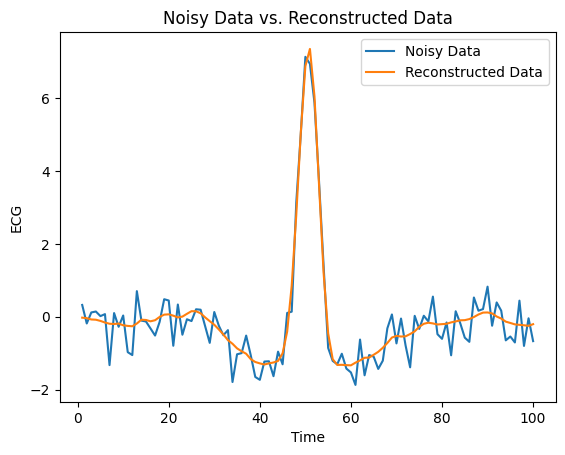

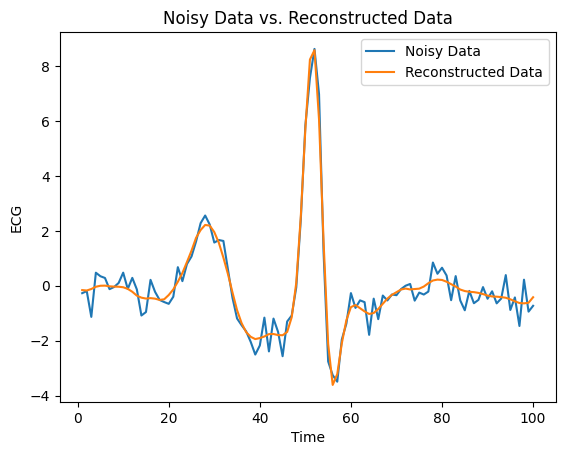

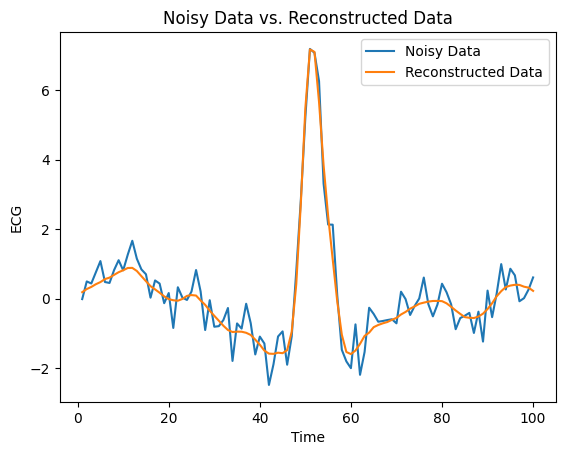

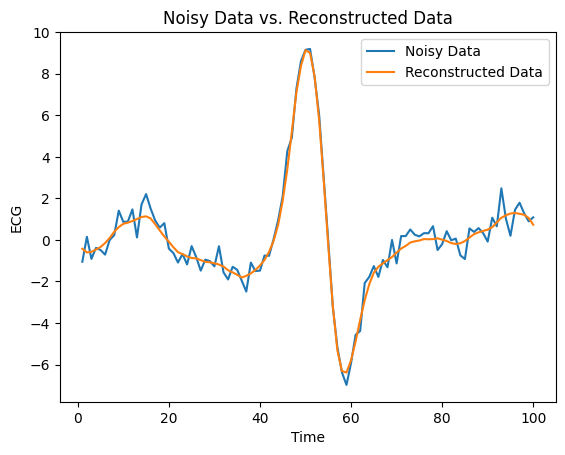

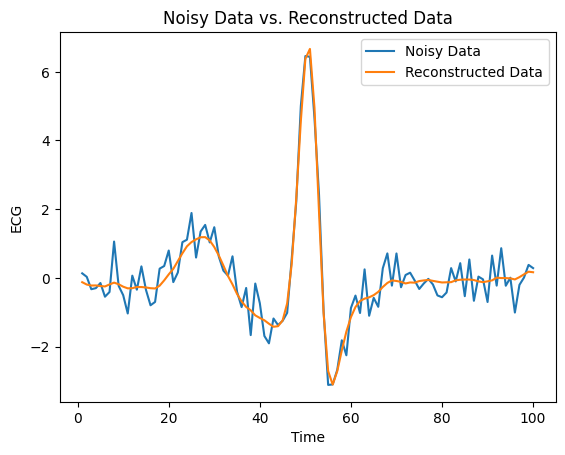

In [9]:
X_pred=model.forward(Xte_noise)
for i in range(5):
    model.plot_loss(Xte_noise[i],X_pred[i])

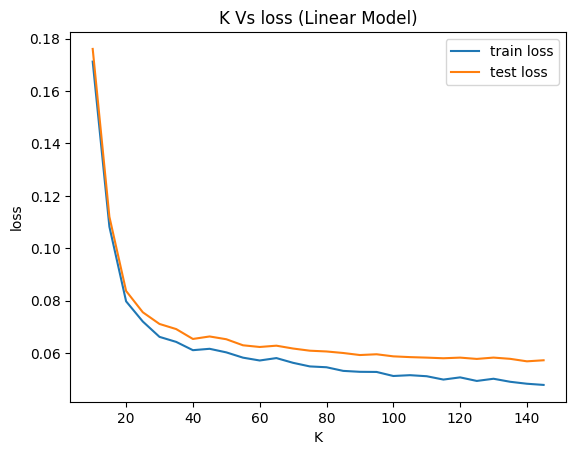

In [10]:
test_loss_lists=[x.cpu().detach().numpy() for x in test_loss_list]
plt.plot(K, train_loss_list, label='train loss')
plt.plot(K, test_loss_lists, label='test loss')
plt.xlabel('K')
plt.ylabel('loss')
plt.title('K Vs loss (Linear Model)')
plt.legend()
plt.show()

In [14]:
test_loss_lists

[array(0.17606921, dtype=float32),
 array(0.11202221, dtype=float32),
 array(0.0837274, dtype=float32),
 array(0.07559882, dtype=float32),
 array(0.07113557, dtype=float32),
 array(0.06918226, dtype=float32),
 array(0.06541365, dtype=float32),
 array(0.06636525, dtype=float32),
 array(0.06530703, dtype=float32),
 array(0.06299788, dtype=float32),
 array(0.06235475, dtype=float32),
 array(0.06284829, dtype=float32),
 array(0.06176087, dtype=float32),
 array(0.06093711, dtype=float32),
 array(0.0606408, dtype=float32),
 array(0.06005921, dtype=float32),
 array(0.05927961, dtype=float32),
 array(0.0595725, dtype=float32),
 array(0.05877917, dtype=float32),
 array(0.05848473, dtype=float32),
 array(0.05829212, dtype=float32),
 array(0.05805062, dtype=float32),
 array(0.058294, dtype=float32),
 array(0.05779989, dtype=float32),
 array(0.05830427, dtype=float32),
 array(0.05782963, dtype=float32),
 array(0.05688161, dtype=float32),
 array(0.05728215, dtype=float32)]

: 